In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# Import Monte Carlo data

In [2]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [3]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")
df_MC_reco

Monte Carlo imported in 0.8357 seconds.


,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
0,0.952388,-0.165336,26.651770,402.777832,-229.470520,5536.814453,0.9524,-0.1653,26.652201,1910.136719,...,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.347290,23634.302734,T,0
1,0.845292,-0.195122,3.622388,139.395874,322.585419,7428.522461,0.8453,-0.1950,3.620400,481.652618,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
2,-0.480003,-0.762014,18.670696,-819.340149,-626.124390,5389.564453,-0.4801,-0.7620,18.671101,-5395.257812,...,-323.442810,2628.927246,4.108163,-790.314697,5651.807129,-5579.078613,-431.151581,23151.667969,T,69
3,1.681797,-2.255294,-36.569271,113.645294,-329.222229,4678.392090,1.6818,-2.2553,-36.569199,7835.708984,...,-1702.511353,24506.517578,8712.822266,-18033.572266,231397.500000,336.531647,-3496.248779,45100.238281,T,119
4,0.824895,-0.252737,74.871048,-100.702072,60.565861,6466.218750,0.8242,-0.2542,74.883598,-74.406654,...,135.662018,8106.856445,-3448.149902,-1045.294434,90591.554688,588.637329,239.301941,10912.332031,T,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366391,0.964920,0.161698,-12.157676,293.129822,39.016293,7097.797363,0.9649,0.1621,-12.151800,3175.616943,...,-18.306223,7767.518555,1504.345581,715.472656,49351.718750,-112.221489,2933.706299,37641.914062,T,8921673
366392,-0.498788,1.215896,21.856564,-176.847626,145.914993,8691.596680,-0.5001,1.2166,21.869101,-2664.720215,...,-50.586430,-2812.631592,-3547.666504,1885.741577,33505.289062,-1337.816284,1466.083374,45027.328125,T,8921702
366393,0.114458,-0.046962,25.276293,-29.465662,-15.364128,949.110657,0.1145,-0.0469,25.275400,-6107.898926,...,-133.646973,15975.192383,-3526.683594,-343.335175,44636.988281,-3534.635254,-3121.734619,91762.195312,T,8921772


In [4]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")
df_MC_truth

Monte Carlo Truth imported in 13.0868 seconds.


,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,mup_PP_X,mup_PP_Y,mup_PP_Z,mup_PP_PX,mup_PP_PY,mup_PP_PZ,mup_PP_Weight,Rec_key,N_rec_matches,TrackType
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,0.6208,-0.5355,21.231701,1448.819824,1628.266357,23763.910156,0.975000,0,1,T
1,0.4619,-0.3471,-52.081200,-19.765400,-33.384300,45.136002,-1190.050049,-1817.560059,5618.410156,-125.169998,...,0.2795,-0.4641,-50.938000,-3430.944092,-2054.681885,20444.863281,1.000000,-1,0,NA
2,0.8623,-0.0693,39.078201,145.114395,-70.015701,2563.685059,1349.000000,-574.190002,22276.189453,239.940002,...,0.1603,-0.3852,34.265598,1869.628418,869.200012,13080.188477,1.000000,-1,0,NA
3,0.8441,-0.1694,17.714300,-9.207400,27.546700,3520.887207,-295.320007,790.229980,93841.296875,3.170000,...,0.4994,-0.5171,14.525300,491.177612,513.784912,5034.924805,1.000000,-1,0,NA
4,0.6610,-0.4327,7.083600,-23.592199,-54.290798,201.384293,-1843.489990,-4303.959961,15525.910156,-361.470001,...,-0.0085,-0.3661,9.187500,-2067.989014,93.588974,6374.103027,1.000000,-1,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921810,0.7382,-0.1062,0.347100,-2.454600,0.459400,68.980499,-1052.079956,169.649994,21721.480469,-270.470001,...,0.5466,-0.3809,3.584800,-1646.731689,-2497.763672,30773.214844,0.942857,-1,0,NA
8921811,0.6401,-0.0814,27.420200,4.920900,-10.475100,58.229698,680.200012,-1542.880005,4852.310059,153.279999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,NA
8921812,2.0908,-1.0901,46.602200,36.268501,-29.632999,1175.768677,4569.680176,-3904.929932,153438.671875,582.070007,...,0.3603,0.4048,30.488100,1073.656860,-936.144836,10031.811523,0.975000,-1,0,NA


In [5]:
len(df_MC_reco)/len(df_MC_truth)

0.04106742854452822

In [6]:
list(df_MC_reco)

['Lb_ENDVERTEX_X',
 'Lb_ENDVERTEX_Y',
 'Lb_ENDVERTEX_Z',
 'L_ENDVERTEX_X',
 'L_ENDVERTEX_Y',
 'L_ENDVERTEX_Z',
 'Jpsi_ENDVERTEX_X',
 'Jpsi_ENDVERTEX_Y',
 'Jpsi_ENDVERTEX_Z',
 'L_PX',
 'L_PY',
 'L_PZ',
 'Lb_PX',
 'Lb_PY',
 'Lb_PZ',
 'Jpsi_PX',
 'Jpsi_PY',
 'Jpsi_PZ',
 'p_PX',
 'p_PY',
 'p_PZ',
 'pim_PX',
 'pim_PY',
 'pim_PZ',
 'mum_PX',
 'mum_PY',
 'mum_PZ',
 'mup_PX',
 'mup_PY',
 'mup_PZ',
 'L_M',
 'L_MM',
 'Lb_M',
 'Lb_MM',
 'Jpsi_M',
 'Jpsi_MM',
 'Lb_BPVDIRA',
 'Lb_BPVIPCHI2',
 'Lb_BPVVDCHI2',
 'Lb_VFASPF_CHI2_VDOF',
 'L_BPVDIRA',
 'L_BPVIPCHI2',
 'L_BPVVDCHI2',
 'L_VFASPF_CHI2_VDOF',
 'Lb_OWNPV_X',
 'Lb_OWNPV_Y',
 'Lb_OWNPV_Z',
 'Lb_OWNPV_CHI2',
 'Lb_OWNPV_NDOF',
 'L_ID',
 'Lb_ID',
 'Jpsi_ID',
 'p_ID',
 'pim_ID',
 'mum_ID',
 'mup_ID',
 'DTF_FixJPsi_status',
 'DTF_FixJPsi_Lb_M',
 'DTF_FixJPsi_Lb_P',
 'DTF_FixJPsi_chi2',
 'DTF_FixJPsi_nDOF',
 'DTF_FixJPsi_PV_key',
 'DTF_FixJPsi_PV_X',
 'DTF_FixJPsi_PV_Y',
 'DTF_FixJPsi_PV_Z',
 'DTF_FixJPsi_L_M',
 'DTF_FixJPsi_L_P',
 'DTF_FixJPsi_L_dec

In [7]:
sum(df_MC_truth['L_Reconstructible'] == 'Neutral')

6687235

In [8]:
sum(df_MC_truth['mup_Reconstructible'].isin(['OutsideAcceptance', 'NotReconstructible']))

278612

In [9]:
prefixList = ['Lb', 'L', 'Jpsi', 'p', 'pim', 'mum', 'mup']
for prefix in prefixList:
    if prefix in ['Lb', 'L', 'Jpsi']:
        isReconstructible = ['Neutral']
        isNotReconstructible = ['OutsideAcceptance']
    elif prefix in ['p', 'pim', 'mum', 'mup']:
        isReconstructible = ['ChargedLong', 'ChargedDownstream', 'ChargedUpstream', 'ChargedTtrack', 'ChargedVelo']
        isNotReconstructible = ['OutsideAcceptance', 'NotReconstructible']        
    
    reconstrucibleEvents = sum(df_MC_truth[prefix + '_Reconstructible'].isin(isReconstructible))
#    nonReconstructableEvents = sum(df_MC_truth[prefix + '_Reconstructible'].isin(isNotReconstructible))
    print(prefix, 'reconstructible events:', reconstrucibleEvents/len(df_MC_truth))

Lb reconstructible events: 0.7621590449925267
L reconstructible events: 0.7495375100245858
Jpsi reconstructible events: 0.7908801067944135
p reconstructible events: 0.7260046302237829
pim reconstructible events: 0.5923704986037034
mum reconstructible events: 0.9687940178091565
mup reconstructible events: 0.9687718250154257


In [10]:
chargedReconstructible = ['ChargedLong', 'ChargedDownstream', 'ChargedUpstream', 'ChargedTtrack', 'ChargedVelo']
neutralReconstructible = ['Neutral']

reconstructibleCondition = (
    (df_MC_truth['Lb_Reconstructible'].isin(neutralReconstructible))
    & (df_MC_truth['L_Reconstructible'].isin(neutralReconstructible))
    & (df_MC_truth['Jpsi_Reconstructible'].isin(neutralReconstructible))
    & (df_MC_truth['p_Reconstructible'].isin(chargedReconstructible))
    & (df_MC_truth['pim_Reconstructible'].isin(chargedReconstructible))
    & (df_MC_truth['mup_Reconstructible'].isin(chargedReconstructible))
    & (df_MC_truth['mum_Reconstructible'].isin(chargedReconstructible))
)

df_MC_reconstructable = df_MC_truth[reconstructibleCondition]
df_MC_reconstructable

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,mup_PP_X,mup_PP_Y,mup_PP_Z,mup_PP_PX,mup_PP_PY,mup_PP_PZ,mup_PP_Weight,Rec_key,N_rec_matches,TrackType
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,0.6208,-0.5355,21.231701,1448.819824,1628.266357,23763.910156,0.975000,0,1,T
2,0.8623,-0.0693,39.078201,145.114395,-70.015701,2563.685059,1349.000000,-574.190002,22276.189453,239.940002,...,0.1603,-0.3852,34.265598,1869.628418,869.200012,13080.188477,1.000000,-1,0,NA
9,2.3967,0.3522,-11.134600,342.488800,-56.340500,1949.822144,2834.850098,-408.519989,15852.820312,498.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,NA
10,0.9063,-0.1799,-33.383598,234.382797,-10.580000,1183.301147,3455.149902,-186.250000,17644.720703,848.739990,...,0.5098,0.3859,-30.139500,-265.161316,391.406616,2115.865723,1.000000,-1,0,NA
12,-0.3182,-0.4103,-32.441502,-1.393900,-1.964200,6.592000,-824.599976,-1249.719971,30170.119141,-259.290009,...,0.0367,-0.3756,-41.133598,-7382.018066,-704.665527,186321.859375,1.000000,-1,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921802,0.9880,-0.0084,-7.648400,43.896599,-253.039505,4871.261719,189.220001,-1679.349976,31407.480469,136.789993,...,0.8878,-0.2953,-10.271800,674.059387,1909.957031,18553.494141,0.972222,-1,0,NA
8921805,1.3503,0.1386,79.210602,466.216705,-259.777405,6610.807129,2698.139893,-1513.589966,37878.039062,182.729996,...,0.0804,-0.2802,66.193298,6057.038086,2028.234131,61998.890625,1.000000,366395,1,T
8921810,0.7382,-0.1062,0.347100,-2.454600,0.459400,68.980499,-1052.079956,169.649994,21721.480469,-270.470001,...,0.5466,-0.3809,3.584800,-1646.731689,-2497.763672,30773.214844,0.942857,-1,0,NA


In [11]:
print("Global reconstructible events:", len(df_MC_reconstructable)/len(df_MC_truth))

Global reconstructible events: 0.3347043174511016


In [12]:
daughterPrefixList = ['p', 'pim', 'mum', 'mup']
for prefix in daughterPrefixList:
    isNotReconstructed = ['NotReconstructed']        
    reconstructedEvents = sum(~df_MC_reconstructable[prefix + '_Reconstructed'].isin(isNotReconstructed))
    print(prefix, 'reconstrution efficiency:', reconstructedEvents/len(df_MC_reconstructable))

p reconstrution efficiency: 0.8746775970557604
pim reconstrution efficiency: 0.7157422383856243
mum reconstrution efficiency: 0.9298010495048842
mup reconstrution efficiency: 0.9281601516323585


In [13]:
isNotReconstructed = ['NotReconstructed']

reconstructedCondition = (
    (~df_MC_reconstructable['p_Reconstructed'].isin(isNotReconstructed))
    & (~df_MC_reconstructable['pim_Reconstructed'].isin(isNotReconstructed))
    & (~df_MC_reconstructable['mup_Reconstructed'].isin(isNotReconstructed))
    & (~df_MC_reconstructable['mum_Reconstructed'].isin(isNotReconstructed))
)

df_MC_reconstructed = df_MC_reconstructable[reconstructedCondition]
df_MC_reconstructed

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,mup_PP_X,mup_PP_Y,mup_PP_Z,mup_PP_PX,mup_PP_PY,mup_PP_PZ,mup_PP_Weight,Rec_key,N_rec_matches,TrackType
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,0.6208,-0.5355,21.231701,1448.819824,1628.266357,23763.910156,0.975000,0,1,T
12,-0.3182,-0.4103,-32.441502,-1.393900,-1.964200,6.592000,-824.599976,-1249.719971,30170.119141,-259.290009,...,0.0367,-0.3756,-41.133598,-7382.018066,-704.665527,186321.859375,1.000000,-1,0,NA
14,0.8581,-0.2143,-37.491299,120.038399,-188.841202,2945.801758,1459.030029,-2458.459961,38212.730469,471.339996,...,0.8465,-0.2601,-37.841000,287.038544,936.053162,3858.562012,0.972973,-1,0,NA
18,-0.6049,0.5641,77.524696,-47.594898,32.898102,567.560730,-2091.340088,1560.229980,22352.830078,-413.670013,...,0.0065,0.0066,58.375099,-2304.014648,2034.613281,70379.101562,0.973684,-1,0,NA
19,0.7327,0.6668,-1.501300,46.128502,69.860901,754.585693,1438.689941,2049.189941,22560.009766,77.809998,...,0.7297,0.6611,-1.494000,-1345.084473,1495.154175,6854.028809,1.000000,-1,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921801,0.9885,0.9508,34.241798,6.157000,50.821499,533.480103,484.279999,4169.029785,42170.851562,77.839996,...,1.1577,0.3087,23.288200,-795.269836,2960.000732,53507.007812,1.000000,-1,0,NA
8921805,1.3503,0.1386,79.210602,466.216705,-259.777405,6610.807129,2698.139893,-1513.589966,37878.039062,182.729996,...,0.0804,-0.2802,66.193298,6057.038086,2028.234131,61998.890625,1.000000,366395,1,T
8921810,0.7382,-0.1062,0.347100,-2.454600,0.459400,68.980499,-1052.079956,169.649994,21721.480469,-270.470001,...,0.5466,-0.3809,3.584800,-1646.731689,-2497.763672,30773.214844,0.942857,-1,0,NA


In [14]:
print("Global reconstruction efficiency:", len(df_MC_reconstructed)/len(df_MC_reconstructable))

Global reconstruction efficiency: 0.5522803457271355


In [15]:
len(df_MC_reco)

366396

In [48]:
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > 5500) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < 8500)]
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
29,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,25203.607422,171.069519,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375
36,0.8594,-0.4530,25.140499,443.537811,-1906.156738,8055.472168,1528.770020,-6513.259766,27549.759766,472.559998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,0.6988,0.1457,8.921400,-275.270508,517.665710,6044.109863,-1734.800049,3088.909912,36901.781250,-165.570007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,0.1737,-0.2302,6.356200,-30.531700,-311.828491,7045.362305,-97.980003,-924.580017,18892.099609,5.040000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,0.5991,-0.2019,37.328098,-31.441000,-262.683105,7216.815430,-199.880005,-1420.540039,36778.171875,-6.320000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921755,0.8836,0.1212,12.387000,185.393295,-125.622803,7188.478516,1751.500000,-1272.150024,71170.023438,553.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921777,1.2719,0.2954,1.781700,220.534607,180.934799,7350.403809,2247.919922,1818.459961,75455.960938,707.440002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921793,0.9531,0.1587,21.349001,361.111511,507.376709,8034.454590,2145.729980,3104.409912,49744.160156,471.799988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
sel_muons_reconstructible = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
sel_ttrack_reconstructible = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
sel_muons_reconstructed = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')
sel_ttrack_reconstructed = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')
sel_reconstructed = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [50]:
selection_total = sel_muons_reconstructible & sel_ttrack_reconstructible & sel_muons_reconstructed & sel_ttrack_reconstructed
selection_pass = selection_total & sel_reconstructed

In [51]:
sum(selection_pass)/sum(selection_total)

0.4337774734526188

In [52]:
from lb2jpsil import pyefficiency

In [64]:
efficiency_vs_vtx = {}
bins_vtx = np.linspace(5500, 8500, 30)

In [65]:
selection_total = sel_muons_reconstructible & sel_ttrack_reconstructible & sel_muons_reconstructed & sel_ttrack_reconstructed
selection_pass = selection_total & sel_reconstructed

eff, _ = pyefficiency.efficiency(
    df_MC['MCTRUTH_L_ENDVERTEX_Z'], bins=bins_vtx, 
    selection_pass=selection_pass,
    selection_total=selection_total
)
efficiency_vs_vtx[r'$\Lambda^0$ & $\Lambda^0_b$ Vertex Reconstruction'] = eff

In [66]:
efficiency_vs_vtx

{'$\\Lambda^0$ & $\\Lambda^0_b$ Vertex Reconstruction': array([[0.39860029, 0.39261637, 0.39853893, 0.4178819 , 0.40557394,
         0.41458126, 0.40896279, 0.42184444, 0.42970629, 0.42959172,
         0.4308823 , 0.43116798, 0.45938492, 0.44778022, 0.44620902,
         0.46988012, 0.46930867, 0.46599956, 0.48513667, 0.50278534,
         0.48868534, 0.4675016 , 0.49022953, 0.40851336, 0.291203  ,
         0.5       , 0.5       , 0.5       , 0.5       ],
        [0.39385028, 0.38785757, 0.39368622, 0.41292299, 0.40058888,
         0.40952821, 0.40391105, 0.41677716, 0.4245643 , 0.4244236 ,
         0.42556897, 0.42572819, 0.45383983, 0.44210636, 0.44037101,
         0.46380771, 0.46313321, 0.45961488, 0.47864246, 0.49600989,
         0.48162135, 0.4592913 , 0.47951104, 0.39348502, 0.20941555,
         0.16      , 0.16      , 0.16      , 0.16      ],
        [0.40336305, 0.39738882, 0.40340497, 0.42285191, 0.41057202,
         0.41964632, 0.41402737, 0.42692271, 0.43485841, 0.4347701 ,
 

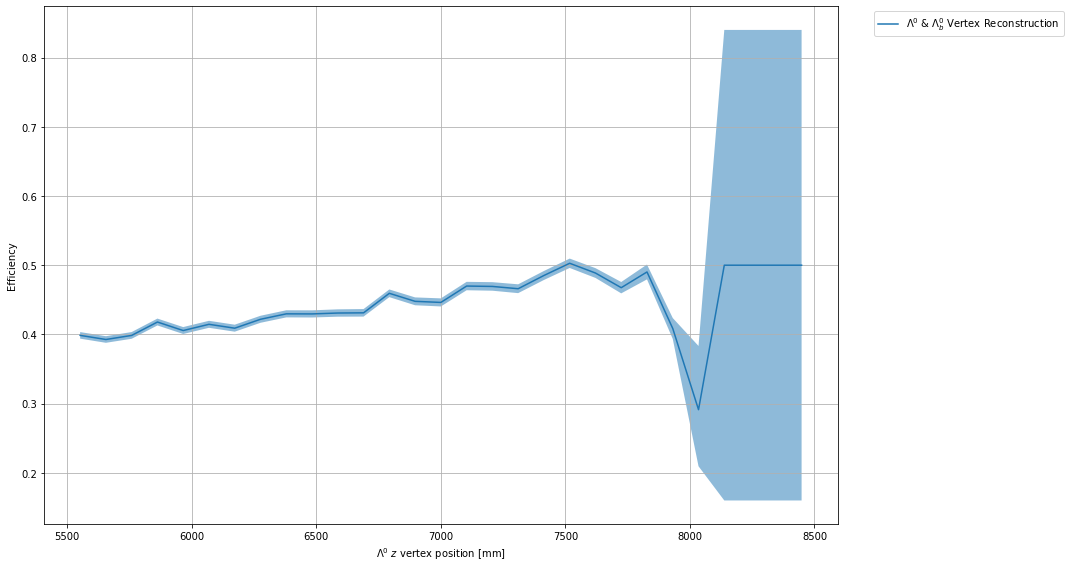

In [67]:
x = (bins_vtx[1:] + bins_vtx[:-1]) / 2
fig = plt.figure(figsize=(15, 8))
for name, eff in efficiency_vs_vtx.items():
    plt.fill_between(x, eff[1], eff[2], alpha=0.5)
    plt.plot(x, eff[0], label=name)
plt.xlabel(r'$\Lambda^0$ $z$ vertex position [mm]')
plt.ylabel('Efficiency')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.savefig('paper_efficiency.pdf')
plt.show()

In [ ]:
## Da fare:
## 1. Ripulire la parte iniziale, fare subito il merge e cancellare i DF inutili
## 2. Capire come funziona pyefficiencies e riprodurlo (perché barre così larghe alla fine?)
## 3. Passare alla parte in cui, err, plotti la roba non ricostruita.
## Suggerisco per l'occasione di produrre due df, uno con eventi ricostruiti e uno senza.
## Idee su cosa plottare:
## - x e y del vertice lambdab e lambda
## - momenti delle particelle figlie
## - basta. Non c'è altro da plottare. Cioè, per capirci conviene plottare tutte le variabili MCTRUTH per capire cosa sono.

In [69]:
list(df_MC_truth)

['MCTRUTH_Lb_ENDVERTEX_X',
 'MCTRUTH_Lb_ENDVERTEX_Y',
 'MCTRUTH_Lb_ENDVERTEX_Z',
 'MCTRUTH_L_ENDVERTEX_X',
 'MCTRUTH_L_ENDVERTEX_Y',
 'MCTRUTH_L_ENDVERTEX_Z',
 'MCTRUTH_p_PX',
 'MCTRUTH_p_PY',
 'MCTRUTH_p_PZ',
 'MCTRUTH_pim_PX',
 'MCTRUTH_pim_PY',
 'MCTRUTH_pim_PZ',
 'MCTRUTH_mum_PX',
 'MCTRUTH_mum_PY',
 'MCTRUTH_mum_PZ',
 'MCTRUTH_mup_PX',
 'MCTRUTH_mup_PY',
 'MCTRUTH_mup_PZ',
 'MCTRUTH_Lb_ID',
 'MCTRUTH_L_ID',
 'Lb_Reconstructible',
 'Lb_Reconstructed',
 'L_Reconstructible',
 'L_Reconstructed',
 'Jpsi_Reconstructible',
 'Jpsi_Reconstructed',
 'p_Reconstructible',
 'p_Reconstructed',
 'pim_Reconstructible',
 'pim_Reconstructed',
 'mum_Reconstructible',
 'mum_Reconstructed',
 'mup_Reconstructible',
 'mup_Reconstructed',
 'p_PP_X',
 'p_PP_Y',
 'p_PP_Z',
 'p_PP_PX',
 'p_PP_PY',
 'p_PP_PZ',
 'p_PP_Weight',
 'pim_PP_X',
 'pim_PP_Y',
 'pim_PP_Z',
 'pim_PP_PX',
 'pim_PP_PY',
 'pim_PP_PZ',
 'pim_PP_Weight',
 'mum_PP_X',
 'mum_PP_Y',
 'mum_PP_Z',
 'mum_PP_PX',
 'mum_PP_PY',
 'mum_PP_PZ',
 'mum